In [0]:
!pip install pybullet


     |████████████████████████████████| 47.4MB 1.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/0b/cf/c0/94af8f5460286129b176b5c3814156c0cfb4d18a47d9cc4d6b
Successfully built pybullet


In [0]:
import numpy as np
import torch
import gym
import argparse
import os

import utils
import DDPG
import pybullet_envs

# Runs policy for X episodes and returns average reward
def evaluate_policy(policy, eval_episodes=10):
	avg_reward = 0.
	for _ in range(eval_episodes):
		obs = env.reset()
		done = False
		while not done:
			action = policy.select_action(np.array(obs))
			obs, reward, done, _ = env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes


if __name__ == "__main__":
  #env=gym.make('InvertedPendulumBulletEnv-v0')
	#env = gym.make('HalfCheetahBulletEnv-v0')
  env = gym.make('HumanoidBulletEnv-v0')
  env = gym.make('AntBulletEnv-v0')

	# Set seeds
  env.seed(0)
  torch.manual_seed(0)
  np.random.seed(0)
	
  reward_plot=[]
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.shape[0] 
  max_action = float(env.action_space.high[0])

	# Initialize policy

  policy = DDPG.DDPG(state_dim, action_dim, max_action)

  replay_buffer = utils.ReplayBuffer()
	
	# Evaluate untrained policy
  evaluations = [evaluate_policy(policy)] 

  total_timesteps = 0
  timesteps_since_eval = 0
  episode_num = 0
  episode_reward = 0
  episode_timesteps = 0
  done = True 

  while total_timesteps <1e6:
		
    if done: 

      if total_timesteps != 0: 
        reward_plot.append(episode_reward)
        print(("Total T: %d Episode Num: %d Episode T: %d Reward: %f") % (total_timesteps, episode_num, episode_timesteps, episode_reward))
        
        policy.train(replay_buffer, episode_timesteps, 100, 0.99, 0.005)
			
			# Evaluate episode
      if timesteps_since_eval >= 5e3:
        timesteps_since_eval %= 5e3
        evaluations.append(evaluate_policy(policy))
				
        policy.save('a3c-cheetah', directory="./pytorch_models")
        np.save("./results/%s" % ('a3c-cheetah'), evaluations) 
			
			# Reset environment
      obs = env.reset()
      done = False
      episode_reward = 0
      episode_timesteps = 0
      episode_num += 1 
		
		# Select action randomly or according to policy
    if total_timesteps < 1e4:
      action = env.action_space.sample()
    else:
      action = policy.select_action(np.array(obs))
    if 0.1 != 0: 
      action = (action + np.random.normal(0, 0.1, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

		# Perform action
    new_obs, reward, done, _ = env.step(action) 
    done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
    episode_reward += reward

		# Store data in replay buffer
    replay_buffer.add((obs, new_obs, action, reward, done_bool))

    obs = new_obs

    episode_timesteps += 1
    total_timesteps += 1
    timesteps_since_eval += 1
		
	# Final evaluation 
  evaluations.append(evaluate_policy(policy))
  policy.save("%s" % ('a3c-cheetah'), directory="./pytorch_models")
  np.save("./results/%s" % ('a3c-cheetah'), evaluations)  


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total T: 1000 Episode Num: 1 Episode T: 1000 Reward: 497.277382
Total T: 1135 Episode Num: 2 Episode T: 135 Reward: 60.477311
Total T: 2135 Episode Num: 3 Episode T: 1000 Reward: 494.893363
Total T: 3135 Episode Num: 4 Episode T: 1000 Reward: 501.062225
Total T: 4135 Episode Num: 5 Episode T: 1000 Reward: 511.345007
Total T: 5135 Episode Num: 6 Episode T: 1000 Reward: 506.337183
Total T: 6135 Episode Num: 7 Episode T: 1000 Reward: 493.774270
Total T: 7135 Episode Num: 8 Episode T: 1000 Reward: 471.670816
Total T: 8135 Episode Num: 9 Episode T: 1000 Reward: 478.790549
Total T: 8155 Episode Num: 10 Episode T: 20 Reward: 1.729655
Total T: 8720 Episode Num: 11 Episode T: 565 Reward: 261.714431
Total T: 9720 Episode Num: 12 Episode T: 1000 Reward: 514.094665
Total T: 10720 Episode Num: 13 Episode T: 1000 Reward: 576.311055
Total T: 11720 Episode Num: 14 Episode T: 1000 Reward: 86.877565
Total T: 12720 Episode Num: 15 Episode T: 1000 Reward: 88.768439
Total T: 13720 Episode Num: 16 Episode T

KeyboardInterrupt: ignored

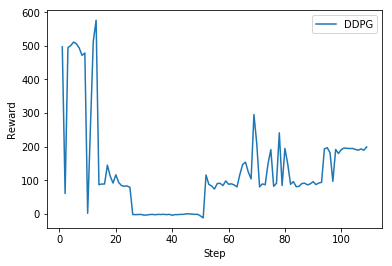

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(1,110),reward_plot,label='DDPG')
plt.ylabel('Reward')
plt.xlabel('Step')
ax.legend()
plt.show()

In [0]:
!mkdir results